# change to 3 class classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from collections import Counter
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold

In [2]:
def write_auc(config, roc_auc):
    file = write_path+'BDT_results.txt'
    with open(file, 'a+') as f:
        aucs = []
        for i in range(0, 3):
            aucs.append(roc_auc[i])
        auc_msg = ','.join(map(str, aucs))
        message = f'{config}; {auc_msg} \n'
        f.write(message)

In [3]:
def write_cm(config, cm_p, cm_e):
    file = write_path+'BDT_cm.txt'
    with open(file, 'a+') as f:
        cm_p_msg = ','.join(map(str, cm_p.flatten().tolist()))
        cm_e_msg = ','.join(map(str, cm_e.flatten().tolist()))
        message = f'{config}; {cm_p_msg}; {cm_e_msg} \n'
        f.write(message)

In [4]:
def plot_roc_curve(fpr, tpr, auc, i):
    ax.plot(fpr, tpr, label=f'{classes[i]} ROC score: {auc:.3f}')
    ax.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend()

In [5]:
def plot_confusion_matrix(y_test, y_pred, classes, figname, w_test=None, normalise_by_col=False, normalise_by_row=False, cmap=plt.cm.Blues):
    if w_test is not None: cm = confusion_matrix(y_test, y_pred, sample_weight=w_test)
    else: cm = confusion_matrix(y_test, y_pred) 
    if normalise_by_col:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print ('Normalised efficiency confusion matrix')
    elif normalise_by_row:
        cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
        print ('Normalised purity confusion matrix')
    else:
        print ('Non-normalised confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='w' if cm[i, j] > thresh else 'k')

    plt.tight_layout(pad=1.4)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(figname)
    print ('Confusion matrix saved as {}'.format(figname))
    return cm

In [6]:
path = '/vols/cms/dw515/Offline/output/SM/masters_signal_vs_background_combined/'
write_path = '/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/'

In [7]:
vbfh_tree = uproot.open(path+'VBFH.root')['ntuple']
ztt_tree = uproot.open(path+'ZTT.root')['ntuple']
fakes_tree = uproot.open(path+'fakes.root')['ntuple']
ggh_tree = uproot.open(path+'ggH.root')['ntuple']

In [8]:
variables = ['pt_1','pt_2', 'm_vis','svfit_mass','mjj','jpt_1','pt_tt','met','n_jets','pt_vis','iso_1','iso_2', 'wt']
selectors = ['rand', 'wt_cp_sm', 'deepTauVsJets_medium_1', 'deepTauVsJets_medium_2', 'trg_doubletau', 'os']

In [9]:
vbfh = vbfh_tree.pandas.df(variables+selectors)
ztt = ztt_tree.pandas.df(variables+selectors)
fakes = fakes_tree.pandas.df(variables+selectors)
ggh = ggh_tree.pandas.df(variables+selectors)

In [10]:
vbfh = vbfh[vbfh['deepTauVsJets_medium_1'] & vbfh['deepTauVsJets_medium_2'] & vbfh['trg_doubletau'] & vbfh['os']]
ztt = ztt[ztt['deepTauVsJets_medium_1'] & ztt['deepTauVsJets_medium_2'] & ztt['trg_doubletau'] & ztt['os']]
fakes = fakes[fakes['deepTauVsJets_medium_1'] & fakes['deepTauVsJets_medium_2'] & fakes['trg_doubletau'] & (fakes['os']==0)]
ggh = ggh[ggh['deepTauVsJets_medium_1'] & ggh['deepTauVsJets_medium_2'] & ggh['trg_doubletau'] & ggh['os']]

In [11]:
scaling = {
    'ggh': 0.0022034,
    'vbfh': 0.0001486,
    'fakes': 1.35,
    'ztt': 3.6292,
}

In [12]:
vbfh.loc[:, 'w'] = vbfh.wt*vbfh.wt_cp_sm *scaling['vbfh']
ztt.loc[:, 'w'] = ztt.wt *scaling['ztt']
fakes.loc[:, 'w'] = fakes.wt *scaling['fakes']
ggh.loc[:, 'w'] = ggh.wt*ggh.wt_cp_sm *scaling['ggh']

In [17]:
vbfh.loc[:, 'h_ind'] = np.ones(vbfh.shape[0])
ztt.loc[:, 'h_ind'] = np.zeros(ztt.shape[0])
fakes.loc[:, 'h_ind'] = np.zeros(fakes.shape[0])
ggh.loc[:, 'h_ind'] = np.full((ggh.shape[0],),2.)

In [18]:
higgs = pd.concat([vbfh, ggh]).reset_index(drop=True)

In [20]:
higgs.loc[:, 'y'] = np.zeros(higgs.shape[0])
ztt.loc[:, 'y'] = np.ones(ztt.shape[0])
fakes.loc[:, 'y'] = np.full((fakes.shape[0],),2.)

In [21]:
higgs.loc[:, 'cn'] = np.full((higgs.shape[0],),928.278)
ztt.loc[:, 'cn'] = np.full((ztt.shape[0],),4.716)
fakes.loc[:, 'cn'] = np.full((fakes.shape[0],),1.278)

In [22]:
df = pd.concat([higgs, ztt, fakes]).reset_index(drop=True)

In [27]:
df = df[df.w > 0]

In [28]:
print(sorted(Counter(df.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [29]:
higgs.w.sum(), ztt.w.sum(), fakes.w.sum()

(927.8508354332606, 36877.137177970326, 136121.85)

In [115]:
vbfh.w.sum(), ggh.w.sum(), ztt.w.sum(), fakes.w.sum()

(109.82523084519048, 818.0256045880701, 36877.137177970326, 136121.85)

# base case

In [90]:
df_1 = df.drop(selectors+['iso_1', 'iso_2'], axis=1)

In [91]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 3000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()


In [92]:
df_1.drop(['y', 'wt', 'w', 'cn', 'h_ind'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis'],
      dtype='object')

In [93]:
X = df_1.drop(['y', 'wt', 'w', 'cn', 'h_ind'], axis=1).to_numpy()
y = df_1.y.astype(int)
w = df_1.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test, h_ind_train, h_ind_test= train_test_split(X, y, w, df_1.cn, df_1.h_ind, test_size=0.3, random_state=1, stratify=df_1.y)

In [95]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, sample_weight=w_train*cn_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train*cn_train, w_test*cn_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

[10:19:26] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.05769	validation_1-mlogloss:1.05757
[2]	validation_0-mlogloss:0.98584	validation_1-mlogloss:0.98543
[4]	validation_0-mlogloss:0.92501	validation_1-mlogloss:0.92440
[6]	validation_0-mlogloss:0.87290	validation_1-mlogloss:0.87208
[8]	validation_0-mlogloss:0.82809	validation_1-mlogloss:0.82707
[10]	validation_0-mlogloss:0.78907	validation_1-mlogloss:0.78790
[12]	validation_0-mlogloss:0.75511	validation_1-mlogloss:0.75382
[14]	validation_0-mlogloss:0.72562	validation_1-mlogloss:0.72422
[16]	validation_0-mlogloss:0.69985	validation_1-mlogloss:0.69837
[18]	validation_0-mlogloss:0.67727	validation_1-mlogloss:0.67567
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [96]:
# skf = StratifiedKFold(n_splits=5)
# for train, test in skf.split(X, y):
#     xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, early_stopping_rounds=50, eval_set=eval_set, eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test)

In [97]:
y_pred = xgb_clf.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

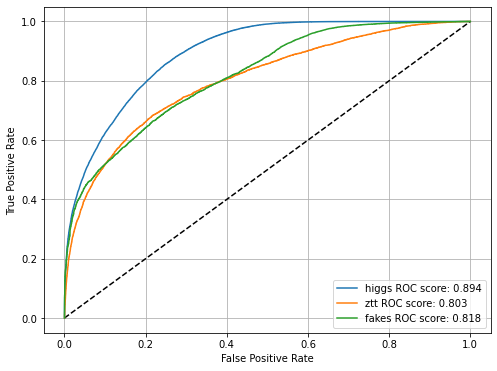

In [98]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')
# 0.792, 0.791, 0.885

In [ ]:
sns.countplot(y_test)
plt.show()

In [ ]:
write_auc('base', roc_auc)

In [ ]:
cr = classification_report(y_test, xgb_clf.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

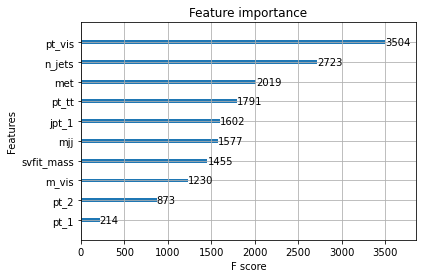

In [29]:
xgboost.plot_importance(xgb_clf).set_yticklabels(df_1.drop(['y','wt','w'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight.png')
plt.show()

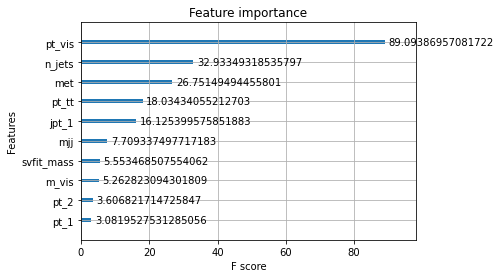

In [30]:
xgboost.plot_importance(xgb_clf, importance_type='gain').set_yticklabels(df_1.drop(['y','wt','w'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain.png')
plt.show()

Normalised purity confusion matrix
[[1.24964622e-02 8.00407409e-04 1.12355379e-04]
 [2.19815702e-01 6.14337322e-01 4.77893267e-02]
 [7.67687836e-01 3.84862271e-01 9.52098318e-01]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity.png
Normalised efficiency confusion matrix
[[0.96675837 0.02439576 0.00884587]
 [0.43060077 0.47412771 0.09527151]
 [0.40655889 0.08030018 0.51314093]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency.png


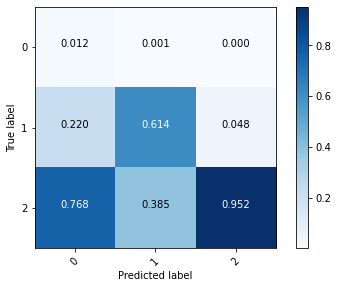

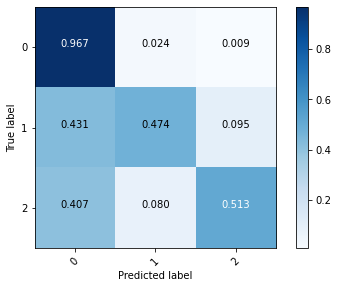

In [38]:
predict=xgb_clf.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency.png')

In [32]:
write_cm('base', cm_p, cm_e)

In [105]:
y_classes=xgb_clf.predict(X_test)

In [106]:
y_pred = xgb_clf.predict_proba(X_test)

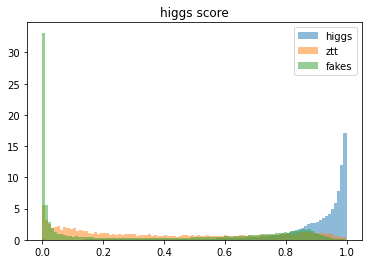

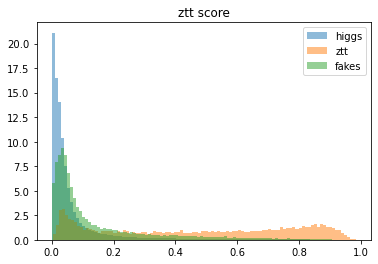

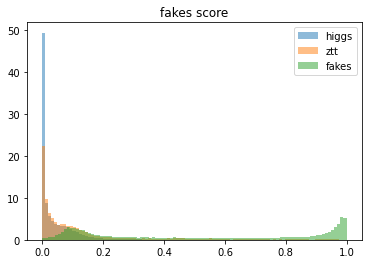

In [107]:
labels=['higgs', 'ztt', 'fakes']
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 0][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[0]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 1][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[1]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 2][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[2]+' score')
plt.legend()
plt.show()

In [108]:
# h_ind_test==1 # vbfh
# h_ind_test==2 # ggh

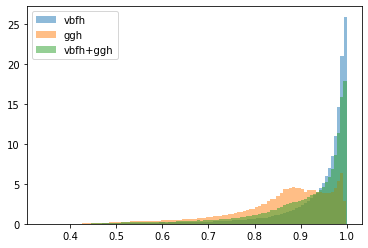

In [109]:
plt.figure()
# plt.hist(y_pred[:, 0][y_test==0], bins=100, label='higgs', alpha=0.5, density=True)
plt.hist(y_pred[:, 0][(y_classes==0) & (h_ind_test==1)], bins=100, label='vbfh', alpha=0.5, density=True)
plt.hist(y_pred[:, 0][(y_classes==0) & (h_ind_test==2)], bins=100, label='ggh', alpha=0.5, density=True)
plt.hist(np.append(y_pred[:, 0][(y_classes==0) & (h_ind_test==1)], y_pred[:, 0][(y_classes==0) & (h_ind_test==2)]), bins=100, label='vbfh+ggh', alpha=0.5, density=True)
plt.legend()
plt.savefig('./signal_background/higgs_vbf_ggh_score.PNG')
plt.show()

In [112]:
y_pred[:, 0][(y_classes==0) & (h_ind_test==1)].shape

(240750,)

In [113]:
y_pred[:, 0][(y_classes==0) & (h_ind_test==2)].shape

(126674,)

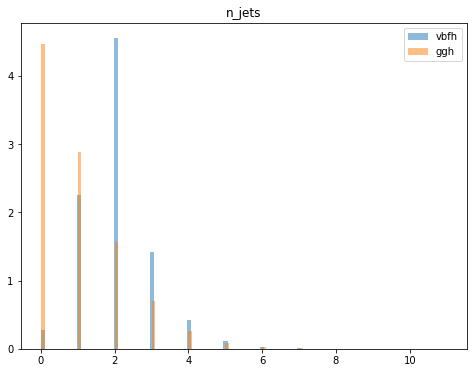

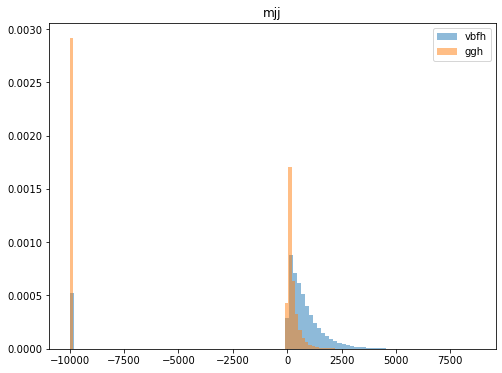

In [120]:
variables = ['n_jets', 'mjj']
for var in variables:
    fig = plt.figure(figsize=(8,6))
    plt.hist(vbfh[var], bins=100, alpha=0.5, density=True, label='vbfh')
#     plt.hist(ztt[var], bins=100, alpha=0.5, density=True, label='ztt')
#     plt.hist(fakes[var], bins=100, alpha=0.5, density=True, label='fakes')
    plt.hist(ggh[var], bins=100, alpha=0.5, density=True, label='ggh')
    plt.title(var)
    plt.legend()
plt.show()

# with iso variables

In [77]:
df_2 = df.drop(selectors, axis=1)

In [78]:
print(sorted(Counter(df_2.y).items()))

[(0.0, 1262736), (1.0, 33487), (2.0, 100831)]


In [80]:
# xgb_params = {
#     "objective": "multi:softmax",
#     "max_depth": 6,
#     "num_classes": 4,
# }
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 3000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [81]:
df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [96]:
X_iso = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y_iso = df_2.y.astype(int)
w_iso = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test= train_test_split(X_iso, y_iso, w_iso, df.cn, test_size=0.3, random_state=1, stratify=df_2.y)

In [97]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train*cn_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train*cn_train, w_test*cn_test))
# xgb_clf.fit(X_train, y_train, sample_weight=w_train, verbose=2, eval_metric="mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:50:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.05679	validation_1-mlogloss:1.05676
[2]	validation_0-mlogloss:0.98316	validation_1-mlogloss:0.98298
[4]	validation_0-mlogloss:0.92054	validation_1-mlogloss:0.92030
[6]	validation_0-mlogloss:0.86669	validation_1-mlogloss:0.86634
[8]	validation_0-mlogloss:0.82017	validation_1-mlogloss:0.81971
[10]	validation_0-mlogloss:0.77957	validation_1-mlogloss:0.77906
[12]	validation_0-mlogloss:0.74425	validation_1-mlogloss:0.74368
[14]	validation_0-mlogloss:0.71327	validation_1-mlogloss:0.71264
[16]	validation_0-mlogloss:0.68609	validation_1-mlogloss:0.68546
[18]	validation_0-mlogloss:0.66202	validation_1-mlogloss:0.66134
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=3000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
X = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y = df_2.y.astype(int)
w = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.3, random_state=1, stratify=df_2.y)

In [43]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf_iso.fit(X_train, y_train, sample_weight=w_train, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_train, w_test))

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:50:23] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.04747	validation_1-mlogloss:1.04743
[2]	validation_0-mlogloss:0.95749	validation_1-mlogloss:0.95736
[4]	validation_0-mlogloss:0.88089	validation_1-mlogloss:0.88071
[6]	validation_0-mlogloss:0.81524	validation_1-mlogloss:0.81503
[8]	validation_0-mlogloss:0.75840	validation_1-mlogloss:0.75829
[10]	validation_0-mlogloss:0.70887	validation_1-mlogloss:0.70895
[12]	validation_0-mlogloss:0.66540	validation_1-mlogloss:0.66565
[14]	validation_0-mlogloss:0.62727	validation_1-mlogloss:0.62763
[16]	validation_0-mlogloss:0.59374	validation_1-mlogloss:0.59446
[18]	validation_0-mlogloss:0.56389	validation_1-mlogloss:0.56473
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [44]:
y_pred = xgb_clf_iso.predict_proba(X_test)
onehot=label_binarize(y_test,classes=[0,1,2])
fpr=dict()
tpr=dict()
thresh = dict()
roc_auc=dict()
for i in range(3):
    fpr[i], tpr[i], thresh[i] = roc_curve(onehot[:,i], y_pred[:,i],sample_weight=w_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

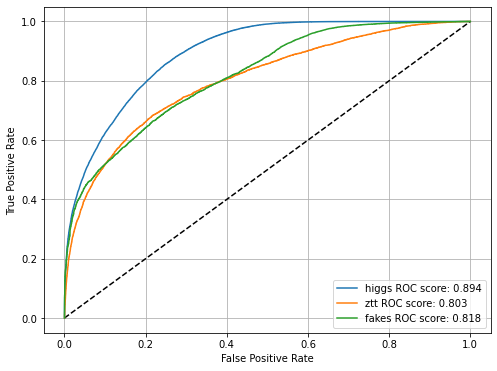

In [84]:
classes = ['higgs', 'ztt', 'fakes']
fig, ax = plt.subplots(figsize=(8,6))
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
# ax.set_xlim(lims)
# ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')
ax.grid()
for i in range(len(fpr)):
    plot_roc_curve(fpr[i],tpr[i],roc_auc[i], i)
# plot_roc_curve(fpr[1],tpr[1],roc_auc[1], 1)
# plot_roc_curve(fpr[2],tpr[2],roc_auc[2], 2)
# plot_roc_curve(fpr[3],tpr[3],roc_auc[3], 3)
# plt.savefig('/signal_background/eda/roc_curves.png')

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


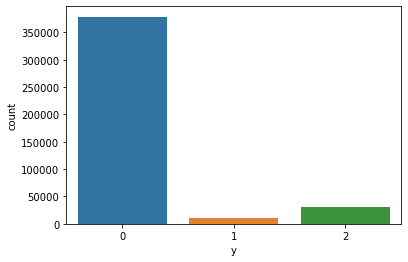

In [50]:
sns.countplot(y_test)
plt.show()

In [42]:
write_auc('with_iso', roc_auc)

In [85]:
cr = classification_report(y_test, xgb_clf_iso.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.015546,0.956612,0.030594,279.545650
ztt,0.724045,0.497688,0.589897,11039.960088
fakes,0.965793,0.647195,0.775029,40836.150000
accuracy,0.617207,0.617207,0.617207,0.617207
macro avg,0.568461,0.700498,0.465174,52155.655738
weighted avg,0.909528,0.617207,0.731852,52155.655738


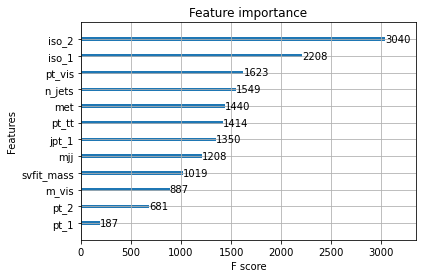

In [51]:
xgboost.plot_importance(xgb_clf_iso).set_yticklabels(df_2.drop(['y','wt','w','cn'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_weight_with_iso.png')
plt.show()

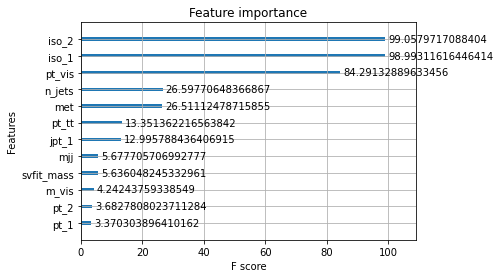

In [52]:
xgboost.plot_importance(xgb_clf_iso, importance_type='gain').set_yticklabels(df_2.drop(['y','wt','w','cn'], axis=1).columns)
plt.savefig('./signal_background/feature_importance_gain_with_iso.png')
plt.show()

Normalised purity confusion matrix
[[1.55455986e-02 9.22690368e-04 1.87361942e-04]
 [2.68256036e-01 7.24044831e-01 3.40194332e-02]
 [7.16198365e-01 2.75032478e-01 9.65793205e-01]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/purity_with_iso.png
Normalised efficiency confusion matrix
[[0.95661155 0.02504739 0.01834106]
 [0.41798713 0.49768807 0.0843248 ]
 [0.30169592 0.05110913 0.64719495]]
Confusion matrix saved as /home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/efficiency_with_iso.png


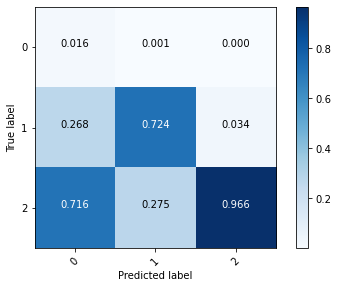

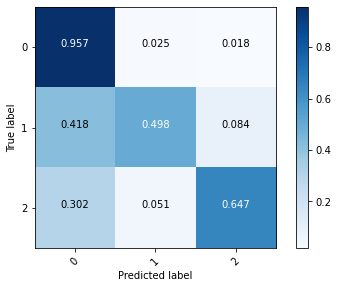

In [86]:
predict=xgb_clf_iso.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity_with_iso.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency_with_iso.png')

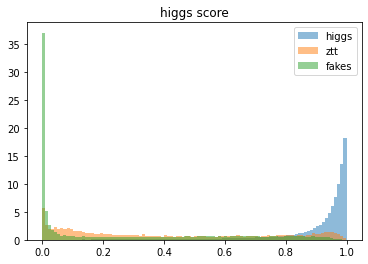

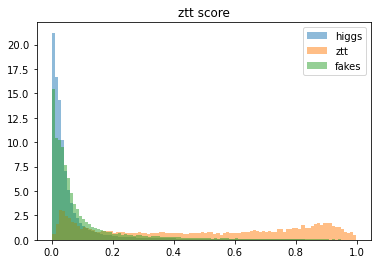

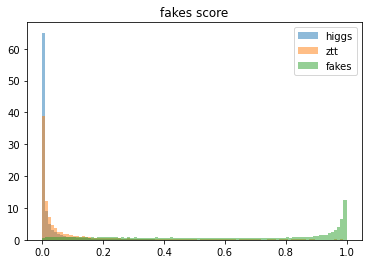

In [99]:
y_classes=xgb_clf_iso.predict(X_test)
y_pred = xgb_clf_iso.predict_proba(X_test)
labels=['higgs', 'ztt', 'fakes']
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 0][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[0]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 1][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[1]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 2][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[2]+' score')
plt.legend()
plt.show()

In [47]:
write_cm('with_iso', cm_p, cm_e)

# use smote on with iso config (weights)


In [21]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [22]:
df_2 = df.drop(selectors, axis=1)

In [23]:
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso_s = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [24]:
df_2.drop(['y', 'wt',  'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2'],
      dtype='object')

In [25]:
X_iso_s = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y_iso_s = df_2.y.astype(int)
w_iso_s = df_2.w
X_train, X_test, y_train, y_test, w_train, w_test, cn_train, cn_test = train_test_split(X_iso_s, y_iso_s, w_iso_s, df.cn, test_size=0.3, random_state=1, stratify=df_2.y)

In [31]:
X_resampled, y_resampled = SMOTE().fit_resample(np.c_[X_train, w_train], y_train)

In [37]:
X_resampled, y_resampled = ADASYN().fit_resample(np.c_[X_train, w_train], y_train)

In [41]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(np.c_[X_train, w_train], y_train)

In [ ]:
smote_enn = SMOTEENN(random_state=0)
# X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
X_resampled, y_resampled = smote_enn.fit_resample(np.c_[X_train, w_train], y_train)

In [45]:
X_m = X_resampled[:, :-1]
w_m = X_resampled[:, -1]

In [46]:
cn_m = np.zeros(len(X_m))
cn_m[y_resampled==0] = 928.278
cn_m[y_resampled==1] = 4.716
cn_m[y_resampled==2] = 1.278

In [47]:
eval_set = [(X_m, y_resampled), (X_test, y_test)]
xgb_clf_iso_s.fit(X_m, y_resampled, sample_weight=w_m*cn_m, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss", sample_weight_eval_set=(w_m*cn_m, w_test*cn_test))

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:00] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.06060	validation_1-mlogloss:1.09785
[2]	validation_0-mlogloss:0.99241	validation_1-mlogloss:1.09630
[4]	validation_0-mlogloss:0.93458	validation_1-mlogloss:1.09834
[6]	validation_0-mlogloss:0.88415	validation_1-mlogloss:1.10168
[8]	validation_0-mlogloss:0.84058	validation_1-mlogloss:1.10591
[10]	validation_0-mlogloss:0.80266	validation_1-mlogloss:1.11099
[12]	validation_0-mlogloss:0.76884	validation_1-mlogloss:1.11636
[14]	validation_0-mlogloss:0.73939	validation_1-mlogloss:1.12231
[16]	validation_0-mlogloss:0.71295	validation_1-mlogloss:1.12683
[18]	validation_0-mlogloss:0.68949	validation_1-mlogloss:1.13059
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [64]:
classes = ['higgs', 'ztt', 'fakes']
cr = classification_report(y_test, xgb_clf_iso_s.predict(X_test), output_dict=True, target_names=classes, sample_weight=w_test)
pd.DataFrame(cr).transpose()

,precision,recall,f1-score,support
higgs,0.999108,0.999245,0.999177,279.545650
ztt,0.999981,0.999977,0.999979,11039.960088
fakes,1.000000,1.000000,1.000000,40836.150000
accuracy,0.999991,0.999991,0.999991,0.999991
macro avg,0.999696,0.999741,0.999719,52155.655738
weighted avg,0.999991,0.999991,0.999991,52155.655738


In [72]:
predict=xgb_clf_iso_s.predict(X_test)
cm_p=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_row=True, w_test=w_test, figname=f'{write_path}purity_with_iso_s.png')
cm_e=plot_confusion_matrix(y_test, predict, [0,1,2],
                    normalise_by_col=True, w_test=w_test, figname=f'{write_path}efficiency_with_iso_s.png')

NotFittedError: need to call fit or load_model beforehand

# S/sqrt(B) study

In [81]:
def SsqrtBPlot(xgb_clf, X, df_1, y, plot=True):
		y_pred = xgb_clf.predict_proba(X)
		y_classes = xgb_clf.predict(X)
		higgs_events = y_classes==0
		higgs_prob = y_pred[higgs_events][:, 0]
		filtered_mask = (higgs_prob>0.9) & (higgs_prob<1)
		filtered_higgs_prob = higgs_prob[filtered_mask]
		def filterprob(start, end):
			filtered_mask = (higgs_prob>start) & (higgs_prob<end)
			filtered_higgs_prob = higgs_prob[filtered_mask]
			return filtered_mask, filtered_higgs_prob
		if plot:
			fig, ax = plt.subplots(1, 5, sharex='col', sharey='row', figsize=(25,5))
		windows = [[0, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 0.95], [0.95, 1]]
		higgs = []
		ztt = []
		fakes = []
		sensitivity_squared = 0
		for i, w in enumerate(windows):
			filtered_mask, filtered_higgs_prob = filterprob(w[0], w[1])
			S_local = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==0].sum()
			ztt_local = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==1].sum()
			fakes_local = df_1.w[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])][y[(y_pred[:, 0]>w[0]) & (y_pred[:, 0]<w[1])]==2].sum()
			B_local = ztt_local + fakes_local
			higgs.append(S_local)
			ztt.append(ztt_local)
			fakes.append(fakes_local)
			sensitivity_squared += (S_local/np.sqrt(B_local))**2
			if plot:
				props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
				# ax[i].set_xlim(w[0], w[1])
				textstr= f"S/sqrt(B)={S_local/np.sqrt(B_local):.4f}\nS={S_local:.3f}\nztt={ztt_local:.3f}\nfakes={fakes_local:.3f}"
				ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14, horizontalalignment='left', verticalalignment='top', bbox=props)
				ax[i].hist(filtered_higgs_prob, bins=100)
		if plot:
			plt.subplots_adjust(wspace=0, hspace=0)
		counts = {
			'higgs': higgs,
			'ztt': ztt,
			'fakes': fakes,
		}
		return np.sqrt(sensitivity_squared), counts

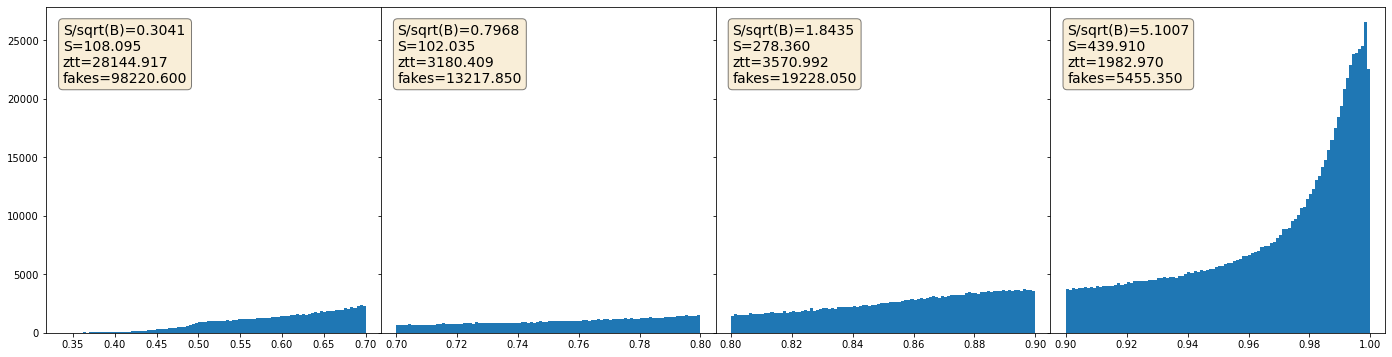

In [111]:
SsqrtBPlot(xgb_clf, X, df_1, y)

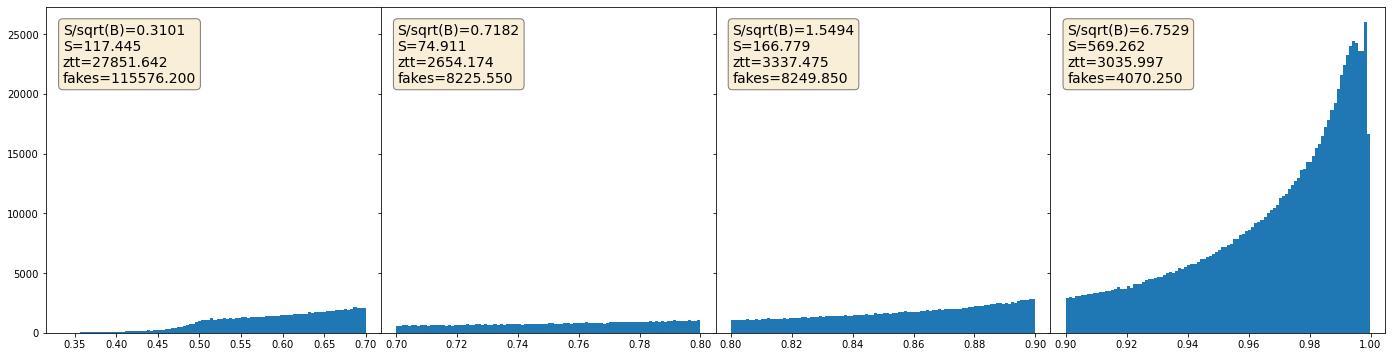

In [98]:
SsqrtBPlot(xgb_clf_iso, X_iso, df_2, y_iso)

# trying unweighted smote


In [63]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from collections import Counter

In [64]:
df_2 = df.drop(selectors, axis=1)

In [65]:
xgb_params = {
    "objective": "multi:softprob",
    "max_depth": 3,
    "learning_rate": 0.05,
    "silent": 1,
    "n_estimators": 1000,
    "subsample": 0.9,
    "seed": 123451,
}

xgb_clf_iso_s = xgboost.XGBClassifier(**xgb_params)
# xgb_clf = xgboost.XGBClassifier()

In [66]:
df_2.drop(['y', 'wt',  'w', 'cn'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'iso_1', 'iso_2', 'h_ind'],
      dtype='object')

In [67]:
X_iso_s = df_2.drop(['y', 'wt', 'w', 'cn'], axis=1).to_numpy()
y_iso_s = df_2.y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X_iso_s, y_iso_s, test_size=0.3, random_state=1, stratify=df_2.y)

In [31]:
X_resampled, y_resampled = SMOTE().fit_resample(np.c_[X_train, w_train], y_train)

In [37]:
X_resampled, y_resampled = ADASYN().fit_resample(np.c_[X_train, w_train], y_train)

In [41]:
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(np.c_[X_train, w_train], y_train)

In [68]:
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

In [69]:
eval_set = [(X_resampled, y_resampled), (X_test, y_test)]
xgb_clf_iso_s.fit(X_resampled, y_resampled, 
                verbose=2, early_stopping_rounds=50, eval_set=eval_set, 
                eval_metric = "mlogloss")

/home/hep/shc3117/anaconda3/envs/msci/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:32:17] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.04742	validation_1-mlogloss:1.02958
[2]	validation_0-mlogloss:0.95727	validation_1-mlogloss:0.90848
[4]	validation_0-mlogloss:0.87945	validation_1-mlogloss:0.80668
[6]	validation_0-mlogloss:0.81285	validation_1-mlogloss:0.71942
[8]	validation_0-mlogloss:0.75386	validation_1-mlogloss:0.64392
[10]	validation_0-mlogloss:0.70296	validation_1-mlogloss:0.57799
[12]	validation_0-mlogloss:0.65711	validation_1-mlogloss:0.52067
[14]	validation_0-mlogloss:0.61664	validation_1-mlogloss:0.47107
[16]	validation_0-mlogloss:0.58077	validation_1-mlogloss:0.42677
[18]	validation_0-mlogloss:0.54850	validation_1-mlogloss:0.38804
[20]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=123451, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=123451, silent=1,
              subsample=0.9, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [74]:
y_pred = xgb_clf_iso_s.predict(X_iso_s)

In [76]:
(y_pred==y_iso_s).sum()/len(y_pred)

0.9879532215648071

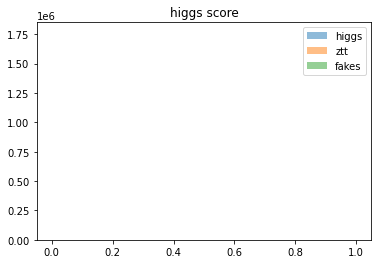

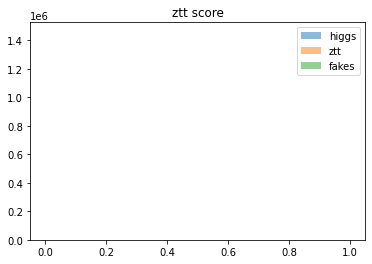

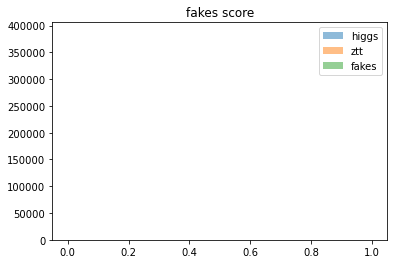

In [84]:
y_classes=xgb_clf_iso_s.predict(X_test)
y_pred = xgb_clf_iso_s.predict_proba(X_test)
labels=['higgs', 'ztt', 'fakes']
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 0][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[0]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 1][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[1]+' score')
plt.legend()
plt.figure()
for i in range(0, 3):
    plt.hist(y_pred[:, 2][y_test==i], bins=100, label=labels[i], alpha=0.5, density=True)
    plt.title(labels[2]+' score')
plt.legend()
plt.show()

<ipython-input-81-59e5a7f57735>:28: RuntimeWarning: invalid value encountered in double_scalars
  sensitivity_squared += (S_local/np.sqrt(B_local))**2
<ipython-input-81-59e5a7f57735>:32: RuntimeWarning: invalid value encountered in double_scalars
  textstr= f"S/sqrt(B)={S_local/np.sqrt(B_local):.4f}\nS={S_local:.3f}\nztt={ztt_local:.3f}\nfakes={fakes_local:.3f}"
<ipython-input-81-59e5a7f57735>:28: RuntimeWarning: invalid value encountered in double_scalars
  sensitivity_squared += (S_local/np.sqrt(B_local))**2
<ipython-input-81-59e5a7f57735>:32: RuntimeWarning: invalid value encountered in double_scalars
  textstr= f"S/sqrt(B)={S_local/np.sqrt(B_local):.4f}\nS={S_local:.3f}\nztt={ztt_local:.3f}\nfakes={fakes_local:.3f}"
<ipython-input-81-59e5a7f57735>:28: RuntimeWarning: invalid value encountered in double_scalars
  sensitivity_squared += (S_local/np.sqrt(B_local))**2
<ipython-input-81-59e5a7f57735>:32: RuntimeWarning: invalid value encountered in double_scalars
  textstr= f"S/sqrt(B)=

(nan,
 {'higgs': [0.0, 0.0, 0.0, 0.0, 928.3994501253388],
  'ztt': [36879.287881444696, 0.0, 0.0, 0.0, 0.0],
  'fakes': [136121.85, 0.0, 0.0, 0.0, 0.0]})

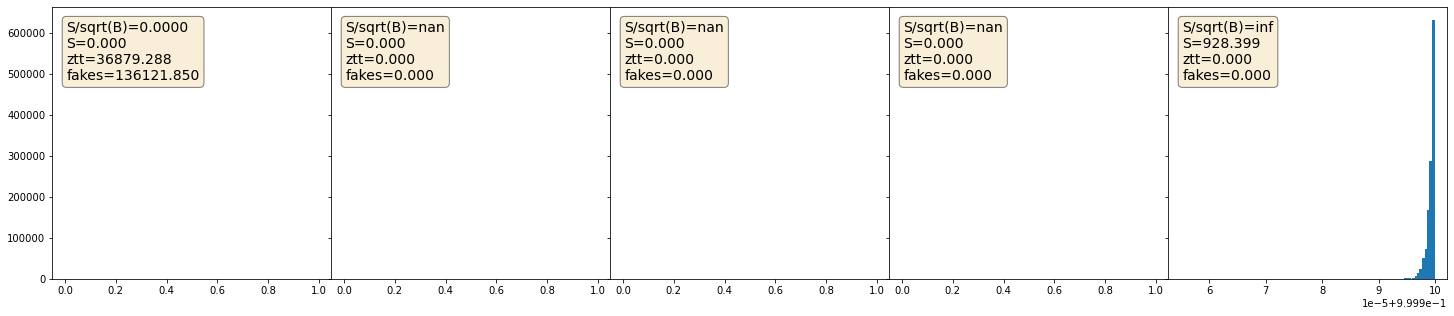

In [82]:
SsqrtBPlot(xgb_clf_iso_s, X_iso_s, df_2, y_iso_s)

In [115]:
xgb_clf_iso.save_model('/home/hep/shc3117/MSci-Project-HiggsTauTau/shared/signal_background/iso.json')

In [104]:
df_1.loc[:, 'y_pred']  = xgb_clf.predict(X)

In [114]:
df_1.drop(['y', 'wt'], axis=1).columns

Index(['pt_1', 'pt_2', 'm_vis', 'svfit_mass', 'mjj', 'jpt_1', 'pt_tt', 'met',
       'n_jets', 'pt_vis', 'w', 'y_pred'],
      dtype='object')

In [148]:
df_test = pd.DataFrame(X_test, columns=df_1.drop(['y', 'wt'], axis=1).columns).reset_index(drop=True)

In [147]:
(y_test==2).sum()

20166

In [149]:
df_test['y'] = y_test.to_numpy()
df_test['w'] = w_test.to_numpy()

In [150]:
df_test['y_pred'] = xgb_clf.predict(X_test)

In [151]:
df_test

,pt_1,pt_2,m_vis,svfit_mass,mjj,jpt_1,pt_tt,met,n_jets,pt_vis,w,y,y_pred
0,92.282034,53.676795,92.767455,115.830387,777.012285,111.839663,138.882213,29.351910,2.0,114.518214,0.000053,0,0
1,41.703584,40.880400,85.186898,101.254921,507.899335,98.537312,23.169485,24.799908,2.0,2.083170,0.000024,0,0
2,129.497680,81.550319,92.653429,124.638680,2601.815534,256.477620,283.144277,88.702454,4.0,195.046717,0.000063,0,0
3,42.768679,40.478256,83.106576,139.588425,970.733272,75.777211,81.928694,77.720337,1.0,6.513472,0.000157,0,0
4,52.635335,52.384945,101.074869,108.849537,169.383822,41.276124,30.110152,9.723588,3.0,39.826468,0.000056,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
198848,86.956464,54.072191,84.667066,98.186611,491.818811,143.600868,144.432830,30.410059,2.0,118.070496,0.000057,0,0
198849,54.342384,50.044678,106.130171,142.722984,-9999.000000,38.905858,51.391301,56.381241,1.0,5.797828,0.000154,0,0
198850,332.635573,71.107560,85.773144,124.196709,809.351633,787.601410,691.283480,294.794250,2.0,396.512134,0.000135,0,0
198851,66.861926,42.956125,105.681926,125.633175,364.414807,94.597766,77.411184,12.334446,3.0,67.925730,0.000063,0,0
